In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import sem

# Plot params
mpl.rcParams.update({'font.size': 9})
mpl.rcParams.update({'font.family': 'Arial'})

FONT_BG = 9

mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

# For later linear regression
from sklearn.linear_model import LinearRegression
def line(x, fit):
    return x * fit.coef_[0] + fit.intercept_

# More plot params
data_col = '#eb0e0e'
mattar_col = '#450c8a'
model_col = '#0ac986'

np.set_printoptions(precision=10, suppress=True)

### Analysis

*Load the data*

In [2]:
d = np.load('./Data/gillespie/GR.npz', allow_pickle=True)

# Various saved quantities
prec = d['prec']
posto = d['posto']
choices = d['choices']
rewards = d['rewards']
goal_seq = d['goal_seq']
num_sessions = d['num_sessions']
num_trials = d['num_trials']

goal_states = [3, 5, 7, 9, 11, 13, 15, 17]
reward_thresh = 15

*GR agent: check proportion of replays that are the current goal, over time*

In [3]:
res = []
raw = []
for sess in range(num_sessions):
    curr_goal = None
    num_trials = goal_seq.shape[1]
    num_blocks = 0
    reward_visit_counter = 0
    goal_replay_counts = []

    for i in range(num_trials):
        # Check for block change
        if curr_goal != goal_seq[sess, i]:
            curr_goal = goal_seq[sess, i]
            num_blocks += 1
        
            if i != 0:
                goal_replay_counts.append(goal_replay_count)
                
            goal_replay_count = np.zeros(reward_thresh)
            reward_visit_counter = 0

        # If rewarded visit, check for post-outcome replay
        if rewards[sess, i] == 1:
            trial_replay = posto[sess,i]
            trial_replay = np.hstack((trial_replay[:, 0], trial_replay[:, 2])) # Splice out action column
            
            if curr_goal in trial_replay or curr_goal - 1 in trial_replay: # Does the current goal feature anywhere?
                goal_replay_count[reward_visit_counter] += 1

            reward_visit_counter += 1

    del goal_replay_counts[0] # Remove the first block because "previous goal" is not well-defined
    if reward_visit_counter > 0:
        goal_replay_counts.append(goal_replay_count) # Add the last block which doesn't meet the condition

    # Stack
    goal_replay_counts = np.array(goal_replay_counts)

    # Check if proportion goes up over time
    x = np.arange(15)
    res.append(np.mean(goal_replay_counts, axis=0))
    
res = np.vstack(res)
avg_goal_replay = np.mean(res, axis=0)

*Gillespie data: load current goal replay data points, replotted from their paper*

In [4]:
y1 = [0.5406301824212272, 0.5439469320066335, 0.6235489220563848, 0.7761194029850746, 0.6666666666666666, 0.7827529021558872, 0.7794361525704809, 1.0281923714759535, 1.1243781094527363, 1.021558872305141, 0.9618573797678276, 1.5422885572139304]
y2 = [0.5804311774461028, 0.5306799336650083, 0.5538971807628524, 0.6898839137645107, 0.7230514096185738, 0.8059701492537313, 0.7097844112769486, 0.9220563847429519, 0.8059701492537313, 0.9485903814262023, 1.2470978441127696, 0.8092868988391376]
y3 = [0.4676616915422886, 0.30514096185737977, 0.3781094527363184, 0.29519071310116085, 0.39469320066334995, 0.2885572139303483, 0.48756218905472637, 0.417910447761194, 0.5306799336650083, 0.6368159203980099, 0.593698175787728, 0.6799336650082919, 0.9618573797678276, 0.9519071310116086, 0.8258706467661692]
y4 = [0.3814262023217247, 0.3482587064676617, 0.23217247097844113, 0.3018242122719735, 0.3117744610281924, 0.3747927031509121, 0.3283582089552239, 0.47761194029850745, 0.4444444444444445, 0.44112769485903813, 0.4709784411276949, 0.41459369817578773, 0.5538971807628524, 0.5970149253731344, 0.5538971807628524]
ys = [np.array(y1), np.array(y2), np.array(y3), np.array(y4)]
xs = [np.arange(2, 2 + len(ys[i])) for i in range(4)]

*GR agent: check how replays decompose in terms of previous block goal, current block goal, and other*

In [5]:
res = []
for sess in range(num_sessions):
    curr_goal = None
    prev_goal = None
    prev_choice = None

    num_trials = goal_seq.shape[1]
    num_blocks = 0

    reward_visit_counter = 0
    replay_counts = np.zeros(4) # _, current goal, previous goal, other

    is_repeat_phase = False
    num_counted_trials = 0
    for i in range(num_trials):
        
        # Check for block change
        if not curr_goal == goal_seq[sess, i]:
            prev_goal = curr_goal
            curr_goal = int(goal_seq[sess, i])
            num_blocks += 1
            is_repeat_phase = False

        if rewards[sess, i] == 1:
            is_repeat_phase = True

        if not is_repeat_phase: # We restrict our attention to repeat phase replay
            continue

        if num_blocks < 2: # We ignore the first block since there is no previous goal
            continue
            
        if i == 0:
            continue
            
        prev_choice = int(choices[sess, i - 1])
        curr_choice = int(choices[sess, i])

        # Restrict attention to trials in which the previous choice is the current choice
        # is the goal.
        if not (goal_states[prev_choice] == curr_goal and prev_choice == curr_choice):
            continue

        # We have a valid trial, let's analyze it
        num_counted_trials += 1
        trial_replay = posto[sess, i]
        trial_replay = np.hstack((trial_replay[:, 0], trial_replay[:, 2]))
        is_other = True

        # Did we replay the current goal?
        if curr_goal in trial_replay or curr_goal - 1 in trial_replay: 
            replay_counts[1] += 1
            is_other = False

        # Did we replay the previous goal?
        if prev_goal in trial_replay or prev_goal - 1 in trial_replay:
            replay_counts[2] += 1
            is_other = False

        # Otherwise we replayed some random arm
        if is_other:
            replay_counts[3] += 1


    # Normalize
    replay_counts /= num_counted_trials
    replay_counts[0] = 1/8 # Uniformly random
    replay_counts[-1] /= 6
    res.append(replay_counts)

gr_comp = np.vstack(res)

*Gillespie data: load replay decomposition data points, replotted from their paper*

In [6]:
data1 = [0.11033134725871738, 0.11780121398927278, 0.13706917703022312, 0.14565885095254308]
data2 = [0.2010553929544678, 0.22474404216407756, 0.2128847219148991, 0.23823329461320578]
data3 = [0.11579259211443861, 0.11106082080670485, 0.1055812038039034, 0.09914807236763908]
gillespie_data = [1/8, np.mean(data1), np.mean(data2), np.mean(data3)]
gillespie_sem = [1/8, sem(data1), sem(data2), sem(data3)]

*Q-learning agent: load the data*

In [7]:
d = np.load('./Data/gillespie/Mattar.npz', allow_pickle=True)

posto = d['posto']
choices = d['choices']
rewards = d['rewards']
goal_seq = d['goal_seq']
num_sessions = d['num_sessions']
num_trials = d['num_trials']

goal_states = [3, 5, 7, 9, 11, 13, 15, 17]
reward_thresh = 15

*Q-learning agent: check proportion of replays that are the current goal, over time*

In [8]:
res = []
for sess in range(num_sessions):
    curr_goal = -1
    num_trials = goal_seq.shape[1]
    num_blocks = 0
    reward_visit_counter = 0
    goal_replay_counts = []

    for i in range(num_trials):
        # Check for block change
        if curr_goal != goal_seq[sess,i]:
            curr_goal = goal_seq[sess,i]
            num_blocks += 1
        
            if i != 0:
                goal_replay_counts.append(goal_replay_count)
                
            goal_replay_count = np.zeros(reward_thresh)
            reward_visit_counter = 0

        # If rewarded visit, check for post-outcome replay
        if rewards[sess,i] == 1:
            trial_replay = posto[sess,i]
            trial_replay = np.hstack((trial_replay[:, 0], trial_replay[:, 2]))
            
            if curr_goal in trial_replay or curr_goal - 1 in trial_replay: # Does the current goal feature anywhere?
                goal_replay_count[reward_visit_counter] += 1

            reward_visit_counter += 1

    del goal_replay_counts[0] # Remove the first one because "previous goal" is not well-defined
    if reward_visit_counter > 0:
        goal_replay_counts.append(goal_replay_count) # Add the last block which doesn't meet the condition

    # Stack
    goal_replay_counts = np.array(goal_replay_counts)

    # Check if proportion goes up over time
    x = np.arange(15)
    res.append(np.mean(goal_replay_counts, axis=0))

    
res = np.vstack(res)
mattar_avg_goal_replay = np.mean(res, axis=0)

*Q-learning agent: check how replays decompose in terms of previous block goal, current block goal, and other*

In [9]:
# Decomposition of all replay events
res = []
for sess in range(num_sessions):
    curr_goal = -1
    prev_goal = None
    prev_choice = None

    num_trials = goal_seq.shape[1]
    num_blocks = 0

    reward_visit_counter = 0
    replay_counts = np.zeros(4) # Random, current goal, previous goal, previous arm, future arm, other

    is_repeat_phase = False
    num_counted_trials = 0
    for i in range(num_trials):
        
        # Check for block change
        if not curr_goal == goal_seq[sess, i]:
            prev_goal = curr_goal
            curr_goal = int(goal_seq[sess, i])
            num_blocks += 1
            is_repeat_phase = False

        if rewards[sess, i] == 1:
            is_repeat_phase = True

        if not is_repeat_phase: # We restrict our attention to repeat phase replay
            continue

        if num_blocks < 2: # We ignore the first block since there is no previous goal
            continue
            
        if i == 0:
            continue
            
        prev_choice = int(choices[sess, i - 1])
        curr_choice = int(choices[sess, i])

        # Restrict attention to trials in which the previous choice is the current choice
        # is the goal.
        if not (goal_states[prev_choice] == curr_goal and prev_choice == curr_choice):
            continue

        # We have a valid trial, let's analyze it
        num_counted_trials += 1
        trial_replay = posto[sess, i]
        trial_replay = np.hstack((trial_replay[:, 0], trial_replay[:, 2]))
        is_other = True

        # Did we replay the current goal?
        if curr_goal in trial_replay or curr_goal - 1 in trial_replay: 
            replay_counts[1] += 1
            is_other = False

        # Did we replay the previous goal?
        if prev_goal in trial_replay or prev_goal - 1 in trial_replay:
            replay_counts[2] += 1
            is_other = False

        # Otherwise we replayed some random arm
        if is_other:
            replay_counts[3] += 1


    # Normalize
    replay_counts /= num_counted_trials
    replay_counts[0] = 1/8 # Uniformly random
    replay_counts[-1] /= 6
    res.append(replay_counts)

mattar_comp = np.vstack(res)

### Plot

*Fig 3B: replay decomposition*

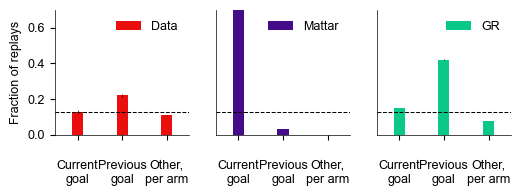

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(5.88, 1.62))
BAR_WIDTH = 0.25

# Data
ax = axes[0]
data1 = [0.11033134725871738, 0.11780121398927278, 0.13706917703022312, 0.14565885095254308]
data2 = [0.2010553929544678, 0.22474404216407756, 0.2128847219148991, 0.23823329461320578]
data3 = [0.11579259211443861, 0.11106082080670485, 0.1055812038039034, 0.09914807236763908]
gillespie_data = [1/8, np.mean(data1), np.mean(data2), np.mean(data3)]
gillespie_sem = [1/8, sem(data1), sem(data2), sem(data3)]
ax.bar(np.arange(4), gillespie_data, color=data_col, label='Data', yerr=gillespie_sem,
       width=BAR_WIDTH, error_kw={'linewidth': 0.5}) 

ax.set_xticks(np.arange(4))
ax.set_xticklabels(['Random', 'Current\ngoal', 'Previous\ngoal', 'Other,\nper arm'])
ax.tick_params(axis='x', which='major', pad=15)
ax.legend(frameon=False)
ax.set_xlim(0.5, 3.5)
ax.axhline(1/8, linestyle='--', color='k', linewidth=0.75)
ax.set_ylim(0, 0.7)
ax.set_ylabel('Fraction of replays')

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Mattar
ax = axes[1]
ax.bar(np.arange(4), np.mean(mattar_comp, axis=0), yerr=sem(mattar_comp, axis=0), label='Mattar', 
       width=BAR_WIDTH, color=mattar_col, error_kw={'linewidth': 0.5})
ax.set_ylim(0, 0.7)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['Random', 'Current\ngoal', 'Previous\ngoal', 'Other,\nper arm'])
ax.tick_params(axis='x', which='major', pad=15)
ax.legend(frameon=False)
ax.set_xlim(0.5, 3.5)
ax.axhline(1/8, linestyle='--', color='k', linewidth=0.75)
ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# GR
ax = axes[2]
ax.bar(np.arange(4), np.mean(gr_comp, axis=0), label='GR', yerr=sem(gr_comp, axis=0),
       width=BAR_WIDTH, color=model_col, error_kw={'linewidth': 0.5})
ax.set_ylim(0, 0.7)
ax.set_yticks([])
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['Random', 'Current\ngoal', 'Previous\ngoal', 'Other,\nper arm'])
ax.tick_params(axis='x', which='major', pad=15)
ax.legend(frameon=False)
ax.set_xlim(0.5, 3.5)
ax.axhline(1/8, linestyle='--', color='k', linewidth=0.75)

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

fig.savefig('./figs/Fig3B_replaydecomposition.pdf', transparent=True)

*Fig 3C: current goal replay over time*

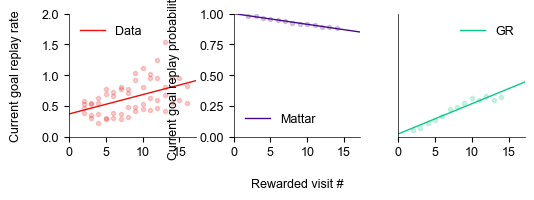

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(5.88, 1.6))

# Data
ax = axes[0]
y1 = [0.5406301824212272, 0.5439469320066335, 0.6235489220563848, 0.7761194029850746, 0.6666666666666666, 0.7827529021558872, 0.7794361525704809, 1.0281923714759535, 1.1243781094527363, 1.021558872305141, 0.9618573797678276, 1.5422885572139304]
y2 = [0.5804311774461028, 0.5306799336650083, 0.5538971807628524, 0.6898839137645107, 0.7230514096185738, 0.8059701492537313, 0.7097844112769486, 0.9220563847429519, 0.8059701492537313, 0.9485903814262023, 1.2470978441127696, 0.8092868988391376]
y3 = [0.4676616915422886, 0.30514096185737977, 0.3781094527363184, 0.29519071310116085, 0.39469320066334995, 0.2885572139303483, 0.48756218905472637, 0.417910447761194, 0.5306799336650083, 0.6368159203980099, 0.593698175787728, 0.6799336650082919, 0.9618573797678276, 0.9519071310116086, 0.8258706467661692]
y4 = [0.3814262023217247, 0.3482587064676617, 0.23217247097844113, 0.3018242122719735, 0.3117744610281924, 0.3747927031509121, 0.3283582089552239, 0.47761194029850745, 0.4444444444444445, 0.44112769485903813, 0.4709784411276949, 0.41459369817578773, 0.5538971807628524, 0.5970149253731344, 0.5538971807628524]
ys = [np.array(y1), np.array(y2), np.array(y3), np.array(y4)]
xs = [np.arange(2, 2 + len(ys[i])) for i in range(4)]

for i in range(4):
    ax.scatter(np.arange(2, 2 + len(ys[i])), ys[i], color=data_col, alpha=0.2, marker='.')

ax.set_ylabel('Current goal replay rate', labelpad=14)
ax.set_ylim(0, 2)
ax.set_xlim(0, 17.2)

X = np.hstack(xs)
Y = np.hstack(ys)

gillespie_fit = LinearRegression().fit(X.reshape(-1, 1), Y)
ax.plot(np.arange(30), line(np.arange(30), gillespie_fit), color=data_col, label='Data', linewidth=1)
ax.legend(frameon=False)
ax.set_xticks(np.arange(0, 20, 5))
ax.set_xticklabels([0, 5, 10, 15])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Mattar
ax = axes[1]
ax.scatter(x[2:], mattar_avg_goal_replay[2:], color=mattar_col, alpha=0.2, marker='.')
ax.set_xlabel('Rewarded visit #', labelpad=14)
ax.set_ylim(0, 1)
ax.set_ylabel('Current goal replay probability', labelpad=14)
ax.set_xlim(0, 17.2)
ax.set_xticks(np.arange(0, 20, 5))
ax.set_xticklabels([0, 5, 10, 15])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Overlay linear regression fit
mattar_fit = LinearRegression().fit(x[2:].reshape(-1, 1), mattar_avg_goal_replay[2:])

ax.plot(np.arange(30), line(np.arange(30), mattar_fit), color=mattar_col, label='Mattar', linewidth=1)
ax.legend(frameon=False)

# GR
ax = axes[2]
ax.scatter(x[2:], avg_goal_replay[2:], color=model_col, alpha=0.2, marker='.')
ax.set_ylim(0, 1)
ax.set_xlim(0, 17.2)
ax.set_xticks(np.arange(0, 20, 5))
ax.set_xticklabels([0, 5, 10, 15])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Overlay linear regression fit
fit = LinearRegression().fit(x[2:].reshape(-1, 1), avg_goal_replay[2:])

ax.plot(np.arange(30), line(np.arange(30), fit), color=model_col, label='GR', linewidth=1)
ax.legend(frameon=False)
plt.subplots_adjust(wspace=0.3)
fig.savefig('./figs/Fig3C_curr_goal_replay.pdf', transparent=True)


*Fig 3D: Decay of fixed goal replay rate over time*

In [12]:
d = np.load('./Data/gillespie/GR.npz', allow_pickle=True)

# Load various saved quantities
prec = d['prec']
posto = d['posto']
choices = d['choices']
rewards = d['rewards']
goal_seq = d['goal_seq']
num_sessions = d['num_sessions']
num_trials = d['num_trials']

goal_states = [3, 5, 7, 9, 11, 13, 15, 17]
reward_thresh = 15

# Convenience analysis functions
def get_session_block_goals(goal_seq):
    block_goals = []
    blockswitch_trials = []
    num_trials = len(goal_seq)
    for i in range(num_trials):
        if block_goals and block_goals[-1] == goal_seq[i]:
            continue
        
        block_goals.append(goal_seq[i])
        blockswitch_trials.append(i)
    
    return block_goals, blockswitch_trials

def check_block_goals_nforward(block_goals, n=3):
    valid_invalid = []
    for bdx, block_goal in enumerate(block_goals):
        # Check existence of bdx + n + 1 (+1 to ensure full repeat phase on block bdx + n)
        if bdx + n + 1 >= len(block_goals): # Not enough blocks to support the future-looking analysis
            valid_invalid.append(False)
            continue
    
        # If there exist enough blocks for i + n to be meaningful
        is_valid = True
        for fdx, future_goal in enumerate(block_goals[bdx+1:bdx+1+n]):
            if future_goal == block_goal:
                is_valid = False
                break
        
        valid_invalid.append(is_valid)
    
    return valid_invalid
            

In [13]:
# GR 
N_BLOCK_FORWARD = 3

search_phase_frac_goal = np.zeros((num_sessions, N_BLOCK_FORWARD))
repeat_phase_frac_goal = np.zeros((num_sessions, N_BLOCK_FORWARD))
search_phase_frac_unrew = np.zeros((num_sessions, N_BLOCK_FORWARD))
repeat_phase_frac_unrew = np.zeros((num_sessions, N_BLOCK_FORWARD))

for sess in range(num_sessions):
    num_trials = goal_seq.shape[1]
    trial_goals = goal_seq[sess, :]
    unrewarded_goals = [g for g in goal_states]
    
    block_goals, switch_trials = get_session_block_goals(trial_goals)
    valid_invalid_blocks = check_block_goals_nforward(block_goals)
    num_valid_blocks = np.sum(valid_invalid_blocks)
    
    # Convenience
    switch_trials.append(num_trials) # Creates a "next block" boundary for the final block
    
    # For each block, see how often its goal is replayed in subsequent blocks
    block_search_phase_frac_goal = np.zeros((num_valid_blocks, N_BLOCK_FORWARD))
    block_repeat_phase_frac_goal = np.zeros((num_valid_blocks, N_BLOCK_FORWARD))
    block_search_phase_frac_unrew = np.zeros((num_valid_blocks, N_BLOCK_FORWARD))
    block_repeat_phase_frac_unrew = np.zeros((num_valid_blocks, N_BLOCK_FORWARD))
    
    vbc = 0 # Valid block counter
    for bdx, block_goal in enumerate(block_goals):
        if block_goal in unrewarded_goals: # Goal will not be unrewarded anymore after block
            unrewarded_goals.remove(block_goal) # Causes a minor bug for search phase tallying
            
        if not valid_invalid_blocks[bdx]: # Invalid block
            continue
        
        for i in range(N_BLOCK_FORWARD):
            fblock_start = switch_trials[bdx + i + 1] # Trial indicating start of the relevant future block
            is_repeat_phase = False # Measure search and repeat phases separately
            unrewarded_goals_future = [goal for goal in unrewarded_goals if goal != block_goals[bdx + i + 1]]
            
            t = fblock_start
            n_repeat_trials = 0
            n_search_trials = 0
            while True:
                if t >= switch_trials[bdx + i + 2]: # Left the future block under consideration
                    break
                
                trial_replay = posto[sess, t]
                trial_replay = np.hstack((trial_replay[:, 0], trial_replay[:, 2]))
                
                # Check if replay contains the reference goal
                if block_goal in trial_replay or block_goal - 1 in trial_replay:
                    if is_repeat_phase:
                        block_repeat_phase_frac_goal[vbc, i] += 1
                    else:
                        block_search_phase_frac_goal[vbc, i] += 1
                
                # Check if replay contains an unrewarded goal
                for unrew_goal in unrewarded_goals_future:
                    if unrew_goal in trial_replay or unrew_goal - 1 in trial_replay:
                        if is_repeat_phase:
                            block_repeat_phase_frac_unrew[vbc, i] += 1 / len(unrewarded_goals)
                        else:
                            block_search_phase_frac_unrew[vbc, i] += 1 / len(unrewarded_goals)
                            
                # Tally trial types
                if is_repeat_phase:
                    n_repeat_trials += 1
                else:
                    n_search_trials += 1
                
                # Update experiment phase
                if rewards[sess, t] == 1:
                    is_repeat_phase = True
                    
                t += 1
                
            block_repeat_phase_frac_goal[vbc, i] /= n_repeat_trials
            block_search_phase_frac_goal[vbc, i] /= n_search_trials
            block_repeat_phase_frac_unrew[vbc, i] /= n_repeat_trials
            block_search_phase_frac_unrew[vbc, i] /= n_search_trials
        
        vbc += 1 # We have processed a valid block in this session
    
    search_phase_frac_goal[sess, :] = np.mean(block_search_phase_frac_goal, axis=0)
    repeat_phase_frac_goal[sess, :] = np.mean(block_repeat_phase_frac_goal, axis=0)
    search_phase_frac_unrew[sess, :] = np.mean(block_search_phase_frac_unrew, axis=0)
    repeat_phase_frac_unrew[sess, :] = np.mean(block_repeat_phase_frac_unrew, axis=0)

GR_rpfg_mean = np.nanmean(repeat_phase_frac_goal, axis=0)
GR_rpfg_std = np.nanstd(repeat_phase_frac_goal, axis=0)

GR_rpfu_mean = np.nanmean(repeat_phase_frac_unrew, axis=0)
GR_rpfu_std = np.nanstd(repeat_phase_frac_unrew, axis=0)

/opt/miniconda3/envs/chess/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/chess/lib/python3.9/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [14]:
# Mattar 
d = np.load('./Data/gillespie/Mattar.npz', allow_pickle=True)

posto = d['posto']
choices = d['choices']
rewards = d['rewards']
goal_seq = d['goal_seq']
num_sessions = d['num_sessions']
num_trials = d['num_trials']

N_BLOCK_FORWARD = 3

search_phase_frac_goal = np.zeros((num_sessions, N_BLOCK_FORWARD))
repeat_phase_frac_goal = np.zeros((num_sessions, N_BLOCK_FORWARD))
search_phase_frac_unrew = np.zeros((num_sessions, N_BLOCK_FORWARD))
repeat_phase_frac_unrew = np.zeros((num_sessions, N_BLOCK_FORWARD))

for sess in range(num_sessions):
    num_trials = goal_seq.shape[1]
    trial_goals = goal_seq[sess, :]
    unrewarded_goals = [g for g in goal_states]
    
    block_goals, switch_trials = get_session_block_goals(trial_goals)
    valid_invalid_blocks = check_block_goals_nforward(block_goals)
    num_valid_blocks = np.sum(valid_invalid_blocks)
    
    # Convenience
    switch_trials.append(num_trials) # Creates a "next block" boundary for the final block
    
    # For each block, see how often its goal is replayed in subsequent blocks
    block_search_phase_frac_goal = np.zeros((num_valid_blocks, N_BLOCK_FORWARD))
    block_repeat_phase_frac_goal = np.zeros((num_valid_blocks, N_BLOCK_FORWARD))
    block_search_phase_frac_unrew = np.zeros((num_valid_blocks, N_BLOCK_FORWARD))
    block_repeat_phase_frac_unrew = np.zeros((num_valid_blocks, N_BLOCK_FORWARD))
    
    vbc = 0 # Valid block counter
    for bdx, block_goal in enumerate(block_goals):
        if block_goal in unrewarded_goals: # Goal will not be unrewarded anymore after block
            unrewarded_goals.remove(block_goal) # Causes a minor bug for search phase tallying
            
        if not valid_invalid_blocks[bdx]: # Invalid block
            continue
        
        for i in range(N_BLOCK_FORWARD):
            fblock_start = switch_trials[bdx + i + 1] # Trial indicating start of the relevant future block
            is_repeat_phase = False # Measure search and repeat phases separately
            unrewarded_goals_future = [goal for goal in unrewarded_goals if goal != block_goals[bdx + i + 1]]
            
            t = fblock_start
            n_repeat_trials = 0
            n_search_trials = 0
            while True:
                if t >= switch_trials[bdx + i + 2]: # Left the future block under consideration
                    break
                
                trial_replay = posto[sess, t]
                trial_replay = np.hstack((trial_replay[:, 0], trial_replay[:, 2]))
                
                # Check if replay contains the reference goal
                if block_goal in trial_replay or block_goal - 1 in trial_replay:
                    if is_repeat_phase:
                        block_repeat_phase_frac_goal[vbc, i] += 1
                    else:
                        block_search_phase_frac_goal[vbc, i] += 1
                
                # Check if replay contains an unrewarded goal
                for unrew_goal in unrewarded_goals_future:
                    if unrew_goal in trial_replay or unrew_goal - 1 in trial_replay:
                        if is_repeat_phase:
                            block_repeat_phase_frac_unrew[vbc, i] += 1 / len(unrewarded_goals)
                        else:
                            block_search_phase_frac_unrew[vbc, i] += 1 / len(unrewarded_goals)
                            
                # Tally trial types
                if is_repeat_phase:
                    n_repeat_trials += 1
                else:
                    n_search_trials += 1
                
                # Update experiment phase
                if rewards[sess, t] == 1:
                    is_repeat_phase = True
                    
                t += 1
                
            block_repeat_phase_frac_goal[vbc, i] /= n_repeat_trials
            block_search_phase_frac_goal[vbc, i] /= n_search_trials
            block_repeat_phase_frac_unrew[vbc, i] /= n_repeat_trials
            block_search_phase_frac_unrew[vbc, i] /= n_search_trials
        
        vbc += 1 # We have processed a valid block in this session
    
    search_phase_frac_goal[sess, :] = np.mean(block_search_phase_frac_goal, axis=0)
    repeat_phase_frac_goal[sess, :] = np.mean(block_repeat_phase_frac_goal, axis=0)
    search_phase_frac_unrew[sess, :] = np.mean(block_search_phase_frac_unrew, axis=0)
    repeat_phase_frac_unrew[sess, :] = np.mean(block_repeat_phase_frac_unrew, axis=0)

Q_rpfg_mean = np.nanmean(repeat_phase_frac_goal, axis=0)
Q_rpfg_std = np.nanstd(repeat_phase_frac_goal, axis=0)

Q_rpfu_mean = np.nanmean(repeat_phase_frac_unrew, axis=0)
Q_rpfu_std = np.nanstd(repeat_phase_frac_unrew, axis=0)

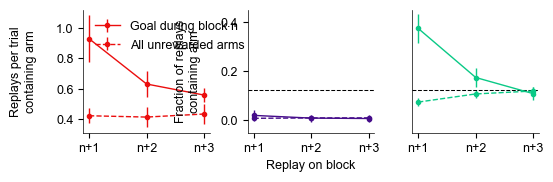

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(5.88, 1.6))

# Data
ax = axes[0]
r1_goal = [1.13450, 0.65205, 0.57895]
r1_other = [0.50292, 0.49708, 0.50000]
r2_goal = [1.00852, 0.76136, 0.61648]
r2_other = [0.40625, 0.41193, 0.40625]
r3_goal = [0.82386, 0.53409, 0.54545]
r3_other = [0.36364, 0.31534, 0.34659]
r4_goal = [0.74074, 0.57835, 0.49573]
r4_other = [0.42450, 0.43875, 0.49003]
data_goal = np.vstack((r1_goal, r2_goal, r3_goal, r4_goal))
data_other = np.vstack((r1_other, r2_other, r3_other, r4_other))

data_goal_mean = np.mean(data_goal, axis=0)
data_goal_std = np.std(data_goal, axis=0)

data_unrew_mean = np.mean(data_other, axis=0)
data_unrew_std = np.std(data_other, axis=0)

ax.errorbar(np.arange(1, 4), data_goal_mean, yerr=data_goal_std, label='Goal during block n', marker='.', color=data_col,
            linewidth=1)
ax.errorbar(np.arange(1, 4), data_unrew_mean, yerr=data_unrew_std, label='All unrewarded arms', marker='.', color=data_col, linestyle='--',
            linewidth=1)

ax.set_ylabel('Replays per trial\ncontaining arm', labelpad=14)
ax.set_xticks([1, 2, 3], ['n+1', 'n+2', 'n+3'])
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
ax.legend(frameon=False)
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Mattar
ax = axes[1]
ax.errorbar(np.arange(1, 4), Q_rpfg_mean, yerr=Q_rpfg_std, label='Goal during block n', marker='.', color=mattar_col, linewidth=1)
ax.errorbar(np.arange(1, 4), Q_rpfu_mean, yerr=Q_rpfu_std, label='All unrewarded arms', marker='.', color=mattar_col, linestyle='--',
            linewidth=1)
ax.axhline(1/8, color='k', linestyle='--', linewidth=0.75)
ax.set_ylim(-0.05, 0.45)
ax.set_ylabel('Fraction of replays\ncontaining arm', labelpad=14)
ax.set_xlabel('Replay on block')
ax.set_xticks([1, 2, 3], ['n+1', 'n+2', 'n+3'])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# GR
ax = axes[2]
ax.errorbar(np.arange(1, 4), GR_rpfg_mean, yerr=GR_rpfg_std, label='Goal during block n', marker='.', color=model_col, linewidth=1)
ax.errorbar(np.arange(1, 4), GR_rpfu_mean, yerr=GR_rpfu_std, label='All unrewarded arms', marker='.', color=model_col, linestyle='--',
            linewidth=1)
ax.axhline(1/8, color='k', linestyle='--', linewidth=0.75)
ax.set_ylim(-0.05, 0.45)
ax.set_yticks([])
ax.set_xticks([1, 2, 3], ['n+1', 'n+2', 'n+3'])
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Adjust and save
plt.subplots_adjust(wspace=0.3)
fig.savefig('./figs/Fig3D_temporal_decay.pdf', transparent=True)